In [ ]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!pip install top2vec
!pip install umap-learn[plot]

In [1]:
import json
import requests
import numpy as np

import umap
import umap.plot
import hdbscan

from top2vec import Top2Vec
from konlpy.tag import Mecab

from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
url = 'http://tools.kinds.or.kr:8888/search/news'

datas = {
    "access_key": "9af2f705-2974-4340-8b55-d69040b944ab",

    "argument": {
        "query": {"title": ""},
        "published_at": {
            "from": "2021-08-29",
            "until": "2021-10-06"
        },
        "provider": [],
        "category": ["008004000"],
        "category_incident": [""],
        "byline": "",
        "provider_subject": [""],
        "subject_info": [""],
        "subject_info1": [""],
        "subject_info2": [""],
        "subject_info3": [""],
        "subject_info4": [""],
        "sort": {"date": "asc"},
        "hilight": 200,
        "return_from": 0,
        "return_size": 10000,
        "fields": [
            "byline",
            "category",
            "category_incident",
            "provider_news_id",
            "hilight",
        ]
    }
}

response = requests.post(url, data=json.dumps(datas))
res = response.json()

In [3]:
total_hits = res['return_object']['total_hits']
print("결과 개수:",total_hits)

결과 개수: 9652


In [4]:
# api데이터로 코퍼스 생성
def create_corpus(total_hits):
    global news_ids
    news_ids, titles, hilights ,title_plus_hilights = [], [], [],[]

    for i in range(total_hits):
        title = res['return_object']['documents'][i]['title']
        hilight = res['return_object']['documents'][i]['hilight']
        news_id = res['return_object']['documents'][i]['news_id']
        news_ids.append(news_id)
        title_plus_hilight = title +","+ hilight
        title_plus_hilights.append(title_plus_hilight)
    len(title_plus_hilights)

    return title_plus_hilights

In [5]:
mecab = Mecab()

In [6]:
# 모델 초기화
model = 0
# Top2vec 임베딩
model = Top2Vec(documents = create_corpus(total_hits), tokenizer = mecab.morphs, umap_args = {'n_neighbors': 15, 'n_components': 5, 'metric': 'cosine', "random_state": 42})

2021-10-10 07:15:18,920 - top2vec - INFO - Pre-processing documents for training
2021-10-10 07:15:23,501 - top2vec - INFO - Creating joint document/word embedding
2021-10-10 07:16:46,229 - top2vec - INFO - Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-10-10 07:17:40,346 - top2vec - INFO - Finding dense areas of documents
2021-10-10 07:17:40,765 - top2vec - INFO - Finding topics


In [7]:
# https://github.com/ddangelov/Top2Vec/blob/master/top2vec/Top2Vec.py
model._get_document_vectors()


array([[ 1.00193007e-04,  7.63838589e-02, -5.97836785e-02, ...,
         2.74522547e-02, -1.36085916e-02,  7.92785287e-02],
       [ 3.43389064e-02, -3.29786688e-02,  1.20393328e-01, ...,
         5.61288036e-02, -1.11562433e-02,  1.38338953e-01],
       [-9.39022079e-02,  2.10752729e-02, -2.98806187e-02, ...,
        -6.41941056e-02, -2.41308212e-02,  9.76029560e-02],
       ...,
       [ 1.18326582e-01, -2.82735862e-02,  2.11245585e-02, ...,
        -6.06078207e-02, -9.24404990e-03, -3.23758349e-02],
       [ 6.88908994e-02, -3.92744169e-02, -1.15789481e-01, ...,
         1.02748275e-01,  6.67568436e-03, -3.15627791e-02],
       [ 6.25320077e-02,  6.74559027e-02, -4.78889011e-02, ...,
        -6.44805059e-02,  2.57825386e-02, -3.05842254e-02]], dtype=float32)

In [8]:
umap_args = {'n_neighbors': 15,
             'n_components': 2,
             'metric': 'cosine'}

mapper = umap.UMAP(**umap_args).fit(model._get_document_vectors(norm=False))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


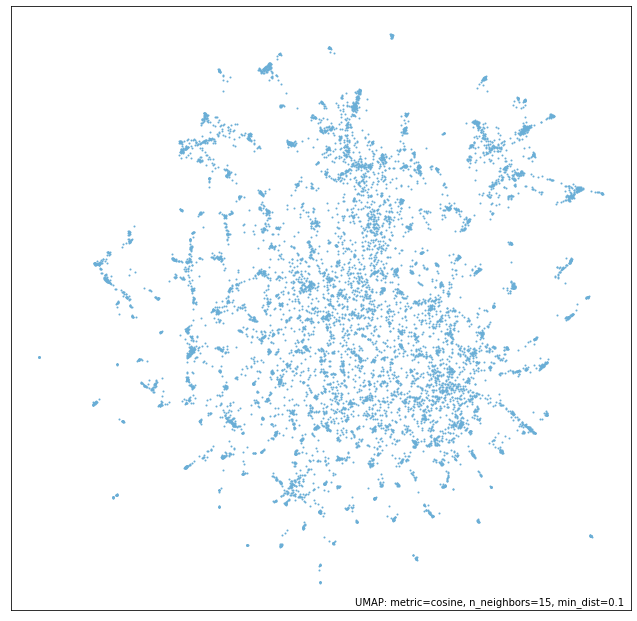

In [9]:
# https://umap-learn.readthedocs.io/en/latest/clustering.html
umap.plot.points(mapper,)


In [10]:
hdbscan_args = {'min_cluster_size': 15,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'}

cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(mapper.embedding_)

In [11]:
cluster.labels_


array([ -1, 147,  35, ...,  -1,  81, 177])

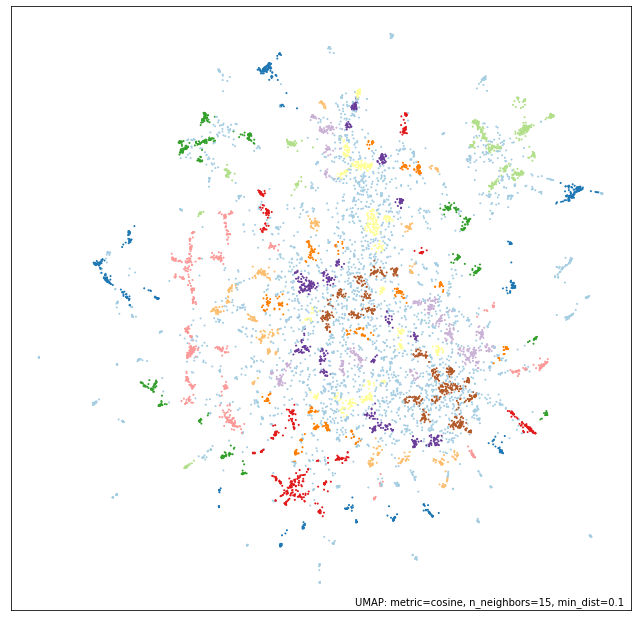

In [12]:
# https://github.com/ddangelov/Top2Vec/blob/master/top2vec/Top2Vec.py
# line 376
#
# https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
umap.plot.points(mapper,cluster.labels_, color_key_cmap='Paired',show_legend=False)

In [13]:
model.get_num_topics()

178

In [14]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([290, 205, 159, 159, 155, 155, 129, 122, 115, 114, 111, 111, 110,
       106, 106, 100, 100,  93,  92,  88,  87,  85,  79,  79,  77,  77,
        77,  75,  75,  75,  74,  74,  73,  72,  71,  70,  68,  68,  66,
        66,  66,  64,  64,  63,  63,  61,  61,  61,  61,  60,  60,  60,
        59,  59,  59,  58,  57,  57,  57,  57,  57,  56,  56,  55,  54,
        53,  53,  52,  52,  52,  51,  51,  51,  50,  50,  50,  50,  50,
        49,  49,  49,  48,  48,  48,  47,  47,  46,  45,  45,  45,  44,
        44,  44,  43,  43,  43,  43,  42,  42,  42,  41,  41,  41,  41,
        41,  40,  40,  39,  39,  39,  38,  38,  38,  38,  38,  36,  36,
        36,  36,  35,  35,  35,  35,  35,  34,  34,  34,  34,  33,  33,
        33,  33,  32,  32,  32,  32,  32,  31,  31,  30,  30,  30,  30,
        29,  29,  29,  29,  28,  28,  28,  27,  27,  27,  27,  27,  27,
        26,  26,  26,  26,  26,  25,  25,  25,  25,  24,  24,  24,  24,
        23,  23,  22,  22,  22,  20,  20,  19,  18])

In [15]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=['넷플릭스'], num_topics=len(topic_sizes))
print(topic_nums[0])
print(topic_scores[0])
tpn = topic_nums[0]
ndc = topic_sizes[18]

3
0.5128763990511342


In [16]:
topic_words, word_scores, topic_nums = model.get_topics()
topic_words[tpn]

array(['플릭스', '패트롤', '83', '집계', '순위', '오징어', '넷플릭스', '드라마', '돌풍', '개국',
       '차지', '오리지널', '위', '인도', '올랐', '현지', '기록', '오르', '기생충', 'CNN',
       '세계', '인기', '일으키', '전', '작품', '시리즈', '미국', '사로잡', '황동혁', '게임',
       '오른', '톱', '영국', '전날', '감독', '사상', '흥행', '외신', '456', '이정재', '세트',
       '프랑스', '사이트', '끌', '시간', '서바이벌', '히트', '현상', '강세', '달고나'],
      dtype='<U6')

In [17]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=tpn, num_docs=ndc)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    if score >= 0.4:
        print(f"Document: {doc_id}, Score: {score}")
        print("-----------")
        print(doc)
        print("-----------")
        print()

Document: 5987, Score: 0.8981500267982483
-----------
'오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위,'오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위 배우 이정재가 주연으로 나선 드라마 ..'오징어 게임'이 한국 작품 최초로 미국 넷플릭스에서 인기 작품 1위를 차지했습니다. .. ..넷플릭스 순위집계 사이트 플릭스 패트롤을 보면 ..'오징어 게임'은 미국에서 1위에 올랐고, 월드 랭킹 TV 쇼 부문에서도 2위를 기록했습니다. .. ..지금까지 한국..
-----------

Document: 8873, Score: 0.8969405293464661
-----------
‘오징어 게임’ 최초 전 세계 1위…춤·노래 없이 인도도 뚫어,‘오징어 게임’ 최초 전 세계 1위…춤·노래 없이 인도도 뚫어 한국의 넷플릭스 오리지널 시리즈 ..‘오징어 게임’이 인도에서도 1위에 올랐다... 이로써 넷플릭스가 정식 서비스되는 83개국에서 1위를 기록한 첫 작품이 됐다... .. .. .. ..2일 글로벌 온라인 동영상 서비스(OTT) 순위 집계 사이트 플릭스 페트롤에 따르면 ..‘오징어 게임’은 ..
-----------

Document: 6529, Score: 0.896016001701355
-----------
'오징어 게임' 한국 드라마 최초 전 세계 넷플릭스 1위,'오징어 게임' 한국 드라마 최초 전 세계 넷플릭스 1위 넷플릭스 오리지널 시리즈 ..'오징어 게임'(감독 황동혁)이 한국 드라마 최초로 전 세계 넷플릭스 1위를 차지했다. .. ..24일(현지 시간) 글로벌 온라인 동영상 서비스(OTT) 순위 집계 사이트 플릭스 패트롤에 따르면 오징어게임이 ..'넷플릭스 인기 TV 프로그램 톱10' 세계 1위로 올랐다..
-----------

Document: 5886, Score: 0.8862784504890442
-----------
전세계가 푹 빠졌다…'오징어게임' 美 넷플릭스서 1위,전세계가 푹 빠졌다…'오징어게

In [18]:
def keyword_extract(doc):
    url = 'http://tools.kinds.or.kr:8888/feature'

    datas = {
        "access_key": "9af2f705-2974-4340-8b55-d69040b944ab",
        "argument": {
            "title": "", 
            "sub_title": "", 
            "content": 
            f"""
            {doc}
            """
            }
    }

    response = requests.post(url, data=json.dumps(datas))
    my_list = response.json()['return_object']['result']['content'].split()
    return [
        i.split("|")[0].replace("_", "")
        for i in my_list
        if float(i.split("|")[1]) > 0.04
    ]

In [19]:
def create_cluster_data(topic_n, score, numdocs):
    topic_words, word_scores, topic_nums = model.get_topics()
    clusters = {
    '000001':{'cluster_name': "오징어게임",'cluster_tag': list(topic_words[topic_n]),'articles':[]},
}

    articles = []
    topic_words, word_scores, topic_nums = model.get_topics()
    top_ten = list(topic_words[topic_n][:11])

    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_n, num_docs=95)
    for doc, score, doc_id in zip(documents, document_scores, document_ids):
        if score >= 0.4:
            temp = []
            article_keyword=keyword_extract(doc)
            x = article_keyword + top_ten
            x = list(set(x))
            articles = {'news_id':news_ids[doc_id],'tag':x,'doc':doc,'score':str(score)}
            clusters['000001']['articles'].append(articles)

    return clusters

In [20]:
json_data = create_cluster_data(topic_n = tpn,score = 0.4,numdocs = ndc)

In [22]:
article_nums = list(range(len(json_data['000001']['articles'])))
corpus = [json_data['000001']['articles'][i]['doc'] for i in article_nums]
tfidfv = TfidfVectorizer(tokenizer = mecab.morphs).fit_transform(corpus)
tfidfv.shape

(95, 750)

In [23]:
document_distances = (tfidfv * tfidfv.T)
document_distances.toarray()[0]

array([1.        , 0.37691187, 0.58136659, 0.50723201, 0.51275742,
       0.39517877, 0.50498133, 0.41347244, 0.52961147, 0.31039646,
       0.71477818, 0.46648227, 0.3946212 , 0.71545083, 0.48784458,
       0.48599765, 0.49406905, 0.35474393, 0.71347697, 0.27180964,
       0.40204883, 0.3964975 , 0.34058269, 0.56517966, 0.34598509,
       0.321886  , 0.64015271, 0.22364731, 0.38692136, 0.43859827,
       0.39681408, 0.38892998, 0.26729731, 0.2990076 , 0.38687951,
       0.49877504, 0.31485502, 0.36811792, 0.37343373, 0.44660702,
       0.31746016, 0.3314239 , 0.30982764, 0.34798301, 0.55680327,
       0.51163521, 0.23566893, 0.36740426, 0.19135919, 0.37108712,
       0.44047753, 0.3295064 , 0.3445881 , 0.40182963, 0.41982481,
       0.34739792, 0.47491093, 0.63882351, 0.3843017 , 0.3685871 ,
       0.44763143, 0.24952719, 0.22528755, 0.35238063, 0.32647051,
       0.47339681, 0.37188249, 0.46225486, 0.32570672, 0.23346837,
       0.37433666, 0.44917173, 0.29440636, 0.52471629, 0.31142

In [24]:
import copy

full_indices_set = set(article_nums)
clustered_indices = []
target = 0
remain_indices = full_indices_set.copy()

while True:
    similarities = document_distances.toarray()[target]
    sim_doc_indices = [i for i, score in enumerate(similarities) if score > 0.3]
    sim_doc_indices = set.intersection(set(sim_doc_indices), remain_indices)
    # sim_doc_list = [json_data['000001']['articles'][i]['doc'] for i in sim_doc_indices]
    clustered_indices.append(sorted(list(sim_doc_indices)))

    remain_indices = remain_indices - set(sim_doc_indices)
    if len(list(remain_indices)) == 0:
        break

    target = list(remain_indices)[0]
    print(target)
clustered_indices


32
69
72
77
78
79
80
48
89
81
90
27


[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  28,
  29,
  30,
  31,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  47,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  63,
  64,
  65,
  66,
  67,
  68,
  70,
  71,
  73,
  74,
  75,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  91,
  92,
  93,
  94],
 [32, 33],
 [69],
 [19, 46, 72, 76],
 [77],
 [61, 78],
 [79],
 [62, 80],
 [48],
 [89],
 [81],
 [90],
 [27]]

In [25]:
for indices in clustered_indices:
    idx = indices[0]
    print(idx, ':', corpus[idx])
    print('-'*200)

0 : '오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위,'오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위 배우 이정재가 주연으로 나선 드라마 ..'오징어 게임'이 한국 작품 최초로 미국 넷플릭스에서 인기 작품 1위를 차지했습니다. .. ..넷플릭스 순위집계 사이트 플릭스 패트롤을 보면 ..'오징어 게임'은 미국에서 1위에 올랐고, 월드 랭킹 TV 쇼 부문에서도 2위를 기록했습니다. .. ..지금까지 한국..
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
32 : ‘오징어 게임’ 넷플릭스 세계 1위…이정재 이어 457번 참가자 등판,‘오징어 게임’ 넷플릭스 세계 1위…이정재 이어 457번 참가자 등판 넷플릭스 오리지널 시리즈 ..‘오징어 게임’이 세계적 돌풍을 일으키고 있다. ..전세계 넷플릭스 TV 프로그램 1위라는 신기록을 세운 데다 미국 넷플릭스에서 4일 연속 ..‘오늘 미국의 톱10 콘텐츠’ 부문 1위에 올랐다. ..25일 플릭스 패트롤에 따르면 ..‘오징어 게임’은 24일..
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
69 : “멕시코에서 ‘오징어 게임’을 만든다면?” 중남미도 사로잡은 K-드라마,“멕시코에서 ..‘오징어 게임’을 만든다면?” 중남미도 사로잡은 K-드라마 넷플릭스의 한국 오리지널 시리즈 ..‘오징어 게임’이 중

In [26]:
date_ls = []
date2doc = {}
for indices in clustered_indices:
    idx = indices[0]
    date = json_data['000001']['articles'][idx]['news_id'][9:]
    doc = json_data['000001']['articles'][idx]['doc']

    date_ls.append(date)
    date2doc[date] = doc
date_ls = sorted(date_ls)

In [27]:
for date in date_ls:
    print(date, ':', date2doc[date])
    print('-'*200)

20210923092602002 : '오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위,'오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위 배우 이정재가 주연으로 나선 드라마 ..'오징어 게임'이 한국 작품 최초로 미국 넷플릭스에서 인기 작품 1위를 차지했습니다. .. ..넷플릭스 순위집계 사이트 플릭스 패트롤을 보면 ..'오징어 게임'은 미국에서 1위에 올랐고, 월드 랭킹 TV 쇼 부문에서도 2위를 기록했습니다. .. ..지금까지 한국..
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
20210923130803001 : '오징어 게임' 美 넷플릭스 재패 기념 미공개 스틸 대방출,'오징어 게임' 美 넷플릭스 재패 기념 미공개 스틸 대방출 넷플릭스 ..'오징어 게임'이 한국 시리즈 최초로 美 넷플릭스 ..'오늘의 Top 10' 1위는 물론 전 세계 40여 개국에서 상위권에 오르는 파란을 일으키고 있는 가운데, 미공개 스틸을 대방출했다. .. ..456억 원의 상금이 걸린 의문의 서바이벌에 참가한 사람들이 최후의 승자가 되기 위해 ..
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
20210925114315001 : ‘오징어 게임’ 넷플릭스 세계 1위…이정재 이어 457번 참가자 등판,‘오징어 게임’ 넷플릭스 세계 1위…이정재 이어 457번 참가

In [57]:
# 1. 타임라인 구성 완료 상태에서 요약후 각각 비교해서 낮은것을 제거 

# 2. 하나를 제외하고 각각 비교

# 3. 코랩에서 사용자사전 집어넣는법.

# 4. 클러스터 연결